<a href="https://colab.research.google.com/github/strawndri/tmcc-voculary/blob/feature%2Freconhecimento-texto/reconhecimento-texto/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Instalações e importações

## 1.1 Bibliotecas

In [1]:
!pip install opencv-python
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install langdetect

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [2]:
import pytesseract as pt
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from langdetect import detect

In [3]:
!mkdir tessdata

mkdir: cannot create directory ‘tessdata’: File exists


In [4]:
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

--2023-09-02 16:48:04--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2023-09-02 16:48:05--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2023-09-02 16:48:05--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awa

## 1.2 Imagens

In [5]:
artigo = 'imagens/artigo.png'
codigo = 'imagens/codigo.png'
nota_fiscal = 'imagens/nota_fiscal.png'
pagina_1 = 'imagens/pagina_1.jpg'
pagina_2 = 'imagens/pagina_2.jpg'
pagina_3 = 'imagens/pagina_3.jpg'
pagina_4 = 'imagens/pagina_4.jpg'
pagina_sombra = 'imagens/pagina_sombra_2.png'

# 2 Tratamento de imagens

In [6]:
def realcar_detalhes(imagem):
    img_redimensionada = cv2.resize(imagem, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    img_suavizada = cv2.GaussianBlur(img_redimensionada, (5, 5), 0)
    img_detalhes = 12 * cv2.subtract(img_redimensionada, img_suavizada)

    return cv2.add(img_redimensionada, img_detalhes)

In [7]:
def ajustar_brilho(imagem, threshold=128, alpha=1.5, beta=50):
    if np.mean(imagem) < threshold:
        return cv2.convertScaleAbs(imagem, alpha=alpha, beta=beta)
    return imagem

In [8]:
def remover_ruindo(imagem):
    sem_ruido = cv2.fastNlMeansDenoisingColored(imagem, None, 10, 10, 7, 21)
    return sem_ruido

In [9]:
def binarizar(imagem):
    _, img_threshold = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if cv2.countNonZero(img_threshold) < (img_threshold.size / 2):
        return 255 - img_threshold
    return img_threshold

# def binarizar(imagem, tamanho_bloco=64):
#     altura, largura = imagem.shape
#     img_resultado = np.zeros_like(imagem)

#     for y in range(0, altura, tamanho_bloco):
#         for x in range(0, largura, tamanho_bloco):
#             bloco = imagem[y:y+tamanho_bloco, x:x+tamanho_bloco]
#             _, bloco_threshold = cv2.threshold(bloco, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#             # Se o bloco é predominantemente preto, inverte
#             if cv2.countNonZero(bloco_threshold) < (bloco_threshold.size / 2):
#                 bloco_threshold = 255 - bloco_threshold

#             img_resultado[y:y+tamanho_bloco, x:x+tamanho_bloco] = bloco_threshold

#     return img_resultado

In [10]:
def avaliar_qualidade_ocr(imagem):
    resultado = pt.image_to_data(imagem, output_type=pt.Output.DICT)
    confiancas = [int(val) for val in resultado['conf'] if str(val).isdigit()]
    if confiancas:
        return sum(confiancas) / len(confiancas)
    return 0

In [11]:
def calcula_angulo(imagem):
    desfocado = cv2.GaussianBlur(imagem, (5, 5), 0)
    bordas = cv2.Canny(desfocado, 50, 150, apertureSize=3)
    linhas = cv2.HoughLines(bordas, 1, np.pi/180, 200)
    if linhas is None:
        return 0
    angulos = [np.degrees(theta) - 90 if np.degrees(theta) - 90 >= 0 else np.degrees(theta) - 90 + 180 for _, theta in linhas[:, 0]]
    return np.median(angulos)

def rotaciona_imagem(imagem, angulo):
    (h, w) = imagem.shape[:2]
    centro = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    rotacionada = cv2.warpAffine(imagem, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotacionada

def ajustar_orientacao(imagem):

    imagem_rotacionada = imagem
    qualidade_desejada = 50.0
    tentativas = 0
    angulo = calcula_angulo(imagem_rotacionada)
    max_qualidade = avaliar_qualidade_ocr(imagem_rotacionada)

    while (max_qualidade < qualidade_desejada):
      imagem_rotacionada = rotaciona_imagem(imagem_rotacionada, angulo)
      max_qualidade = avaliar_qualidade_ocr(imagem_rotacionada)
      tentativas += 1
      angulo += 90

      if tentativas == 2:
        break

    return imagem_rotacionada

# 3 Detecção e extração de textos

In [12]:
def determinar_psm(imagem):
    pixels_pretos = imagem.size - cv2.countNonZero(imagem)
    proporcao_preto = pixels_pretos / imagem.size

    if proporcao_preto > 0.2:
        return '6'
    else:
        return '1'

In [13]:
def detectar_idioma(imagem):
    codigos = {
        'en': 'eng',
        'pt': 'por'
    }

    try:
        cod_idioma = codigos[detect(pt.image_to_string(imagem))]
    except:
        cod_idioma = 'eng'

    return cod_idioma

In [14]:
def extrair_texto(imagem):

    imagem = cv2.imread(imagem)
    imagem = realcar_detalhes(imagem)
    imagem = ajustar_brilho(imagem)
    # imagem = remover_ruindo(imagem)
    img_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)

    img_binarizada = binarizar(img_cinza)
    imagem_final = ajustar_orientacao(img_binarizada)

    psm_valor = determinar_psm(imagem_final)
    cod_idioma = detectar_idioma(imagem_final)

    resultado = pt.image_to_data(imagem_final,
                               lang=cod_idioma,
                               config=f'--tessdata-dir tessdata --psm {psm_valor}',
                               output_type=pt.Output.DICT)

    texto_filtrado = [resultado['text'][i] for i in range(len(resultado['conf'])) if int(resultado['conf'][i] >= min_conf)]
    texto = ' '.join(texto_filtrado)

    return imagem_final, texto

# 4 Testes de OCR

In [15]:
min_conf = 50 #@param {type: 'slider', min:0,max: 100}

## 4.1 Segmentação textual

Neste capítulo, busca-se analisar o processo de OCR diante de imagens com diferentes disposições textuais, observando os seguintes aspectos:

* Verticalidade;
* Horizontalidade;
* Organização em formato de bloco;
* Organização em formato de linha.

> **O que é esperado?** *Que o programa seja capaz de reconhecer a natureza da imagem e se adaptar com vistas a detectar de forma inteligente seu texto.*


### 4.1.1 Trecho de artigo

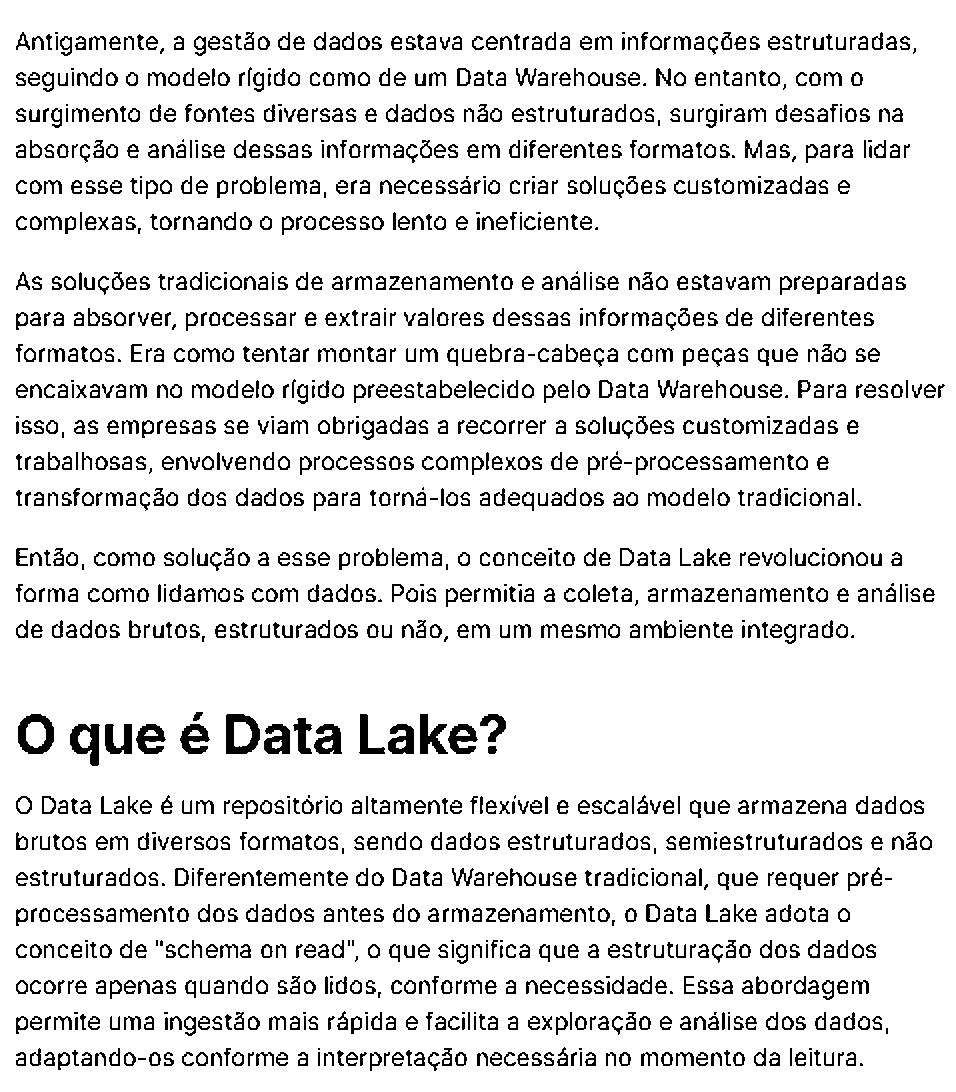

'Antigamente, a gestão de dados estava centrada em informações estruturadas, seguindo o modelo rígido como de um Data Warehouse. No entanto, com o surgimento de fontes diversas e dados não estruturados, surgiram desafios na absorção e análise dessas informações em diferentes formatos. Mas, para lidar com esse tipo de problema, era necessário criar soluções customizadas e complexas, tornando o processo lento e ineficiente. As soluções tradicionais de armazenamento e análise não estavam preparadas para absorver, processar e extrair valores dessas informações de diferentes formatos. Era como tentar montar um quebra-cabeça com peças que não se encaixavam no modelo rígido preestabelecido pelo Data Warehouse. Para resolver i8so, empresas se viam obrigadas a recorrer a soluções customizadas e trabalhosas, envolvendo processos complexos de pré-processamento e transformação dos dados para torná-los adequados ao modelo tradicional. Então, como solução à esse problema, o conceito de Data Lake rev

In [16]:
imagem, texto = extrair_texto(artigo)
cv2_imshow(imagem)
texto

### 4.1.2 Trecho de código do Visual Studio Code

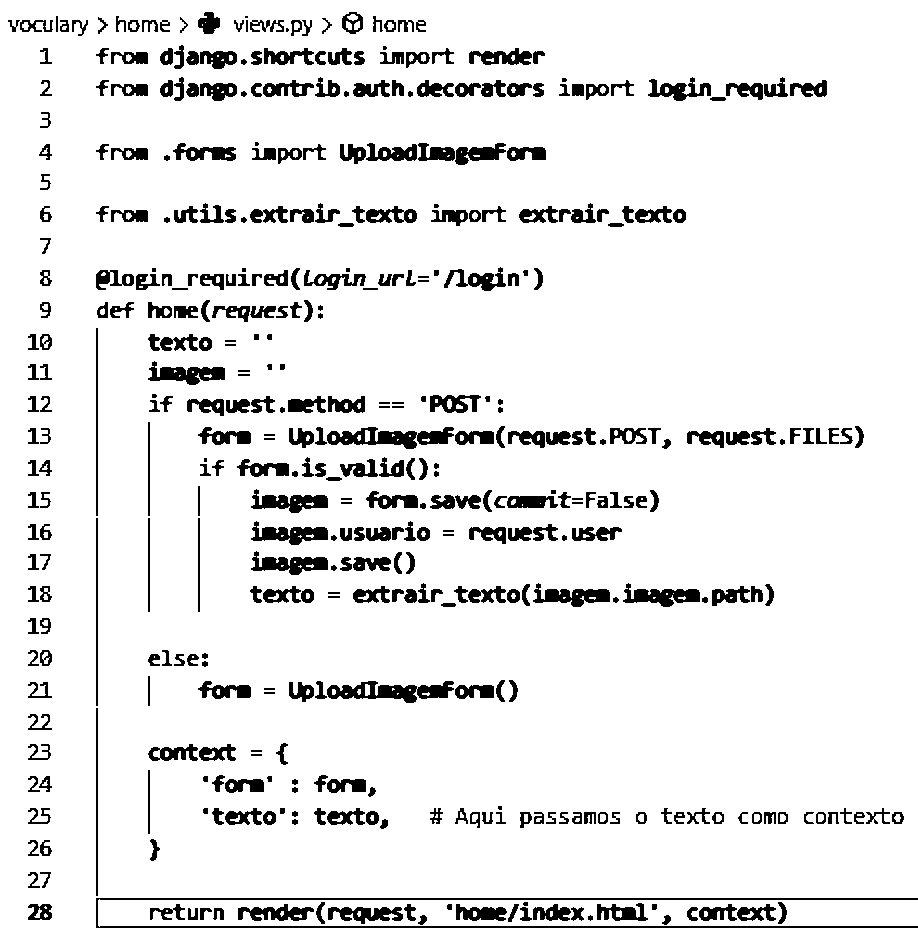

'voculary » home > views.py > @ home 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 26 27 from django.shortcuts import render from django.contrib.auth.decorators import login_required from .forms import from .utils.extrair_texto import extrair_texto @login_required(Login url="/login") def home(reguest): texto = ** imagem = if request.method == form = request.FILES) if form.is_valid(): | = images.usuario = request.user texto = else: form = UploadImagesForm() context = { : form, texto, # Aqui passamos o texto contexto }     return render(request, ‘home/index.html’, comtext) '

In [17]:
imagem, texto = extrair_texto(codigo)
cv2_imshow(imagem)
texto

### 4.1.3 Nota fiscal

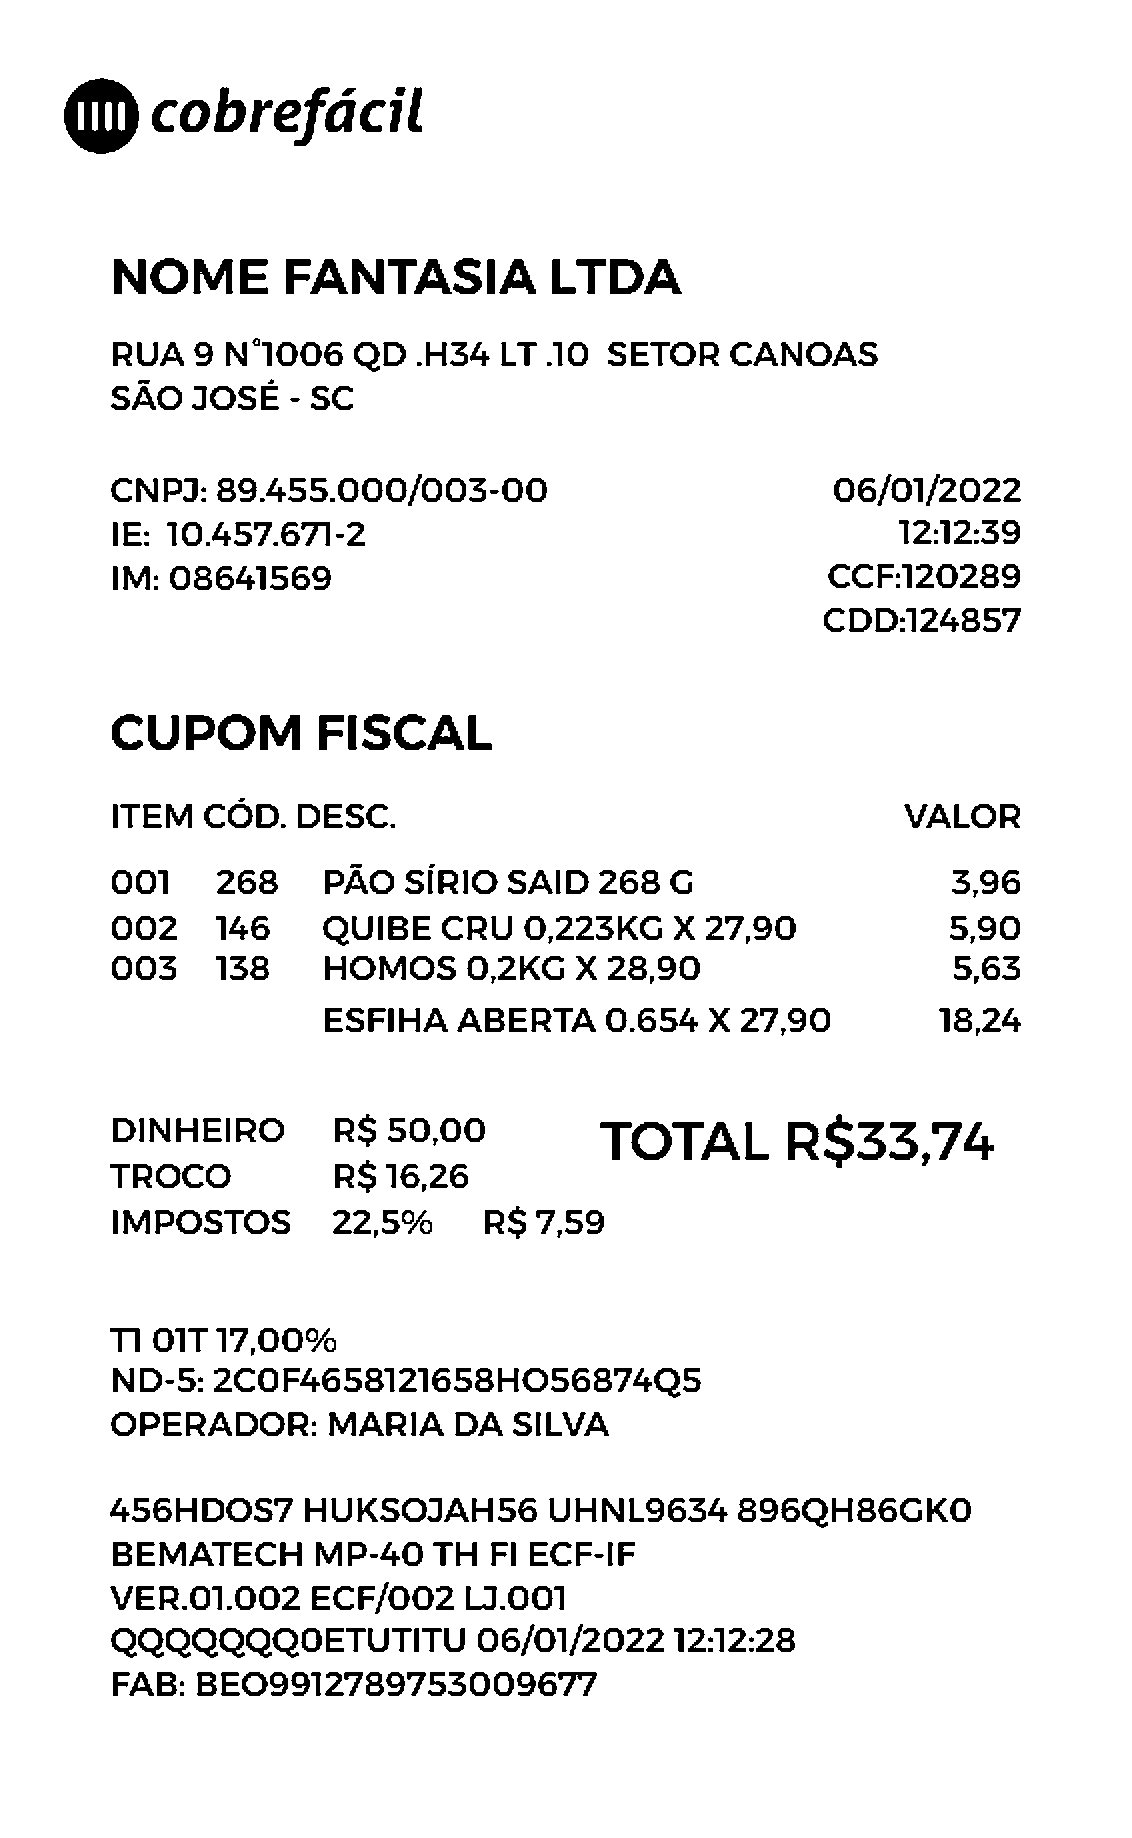

'@ NOME FANTASIA LTDA RUA 9 N"1006 QD .H34 LT .10 SETOR CANOAS SAO JOSE - SC 89.455.000/003-00 06/01/2022 IE: 10.457.671-2 12:12:39 IM: 08641569 CCF:120289 CDD:124857 CUPOM FISCAL ITEM COD. DESC. VALOR 001 268 PAO SIRIOSAID 268G 3,96 002 146 QUIBE CRU 0,223KG X 27,90 5,90 003 138 HOMOS 0,2KG X 28,90 5,63 ESFIHA ABERTA 0.654 X 27,90 18,24 DINHEIRO R$ 50,00 TOTAL R$33,74 TROCO IMPOSTOS 225% R$759 T1 01T 17,00% ND-5: OPERADOR: MARIA DA SILVA 456HDOS7 HUKSOJAH56 UHNL9634 896QHB6GKO BEMATECH MP-40 TH ECF-IF VER.01.002 ECF/002 L1.001 QQQQQQQOETUTITU 06/01/2022 12:12:28 FAB: BEO9912789753009677'

In [18]:
imagem, texto = extrair_texto(nota_fiscal)
cv2_imshow(imagem)
texto

## 4.2 Orientação

O objetivo deste capítulo é analisar como a detecção de caracteres se comporta diante de imagens com diferentes orientações.

> **O que é esperado?** *Independente do ângulo de inclinação da imagem, o programa deverá ser capaz de rotacioná-la de modo que seu texto fique reto e esteja organizado de cima para baixo.*

### 4.2.1 Imagem na horizontal

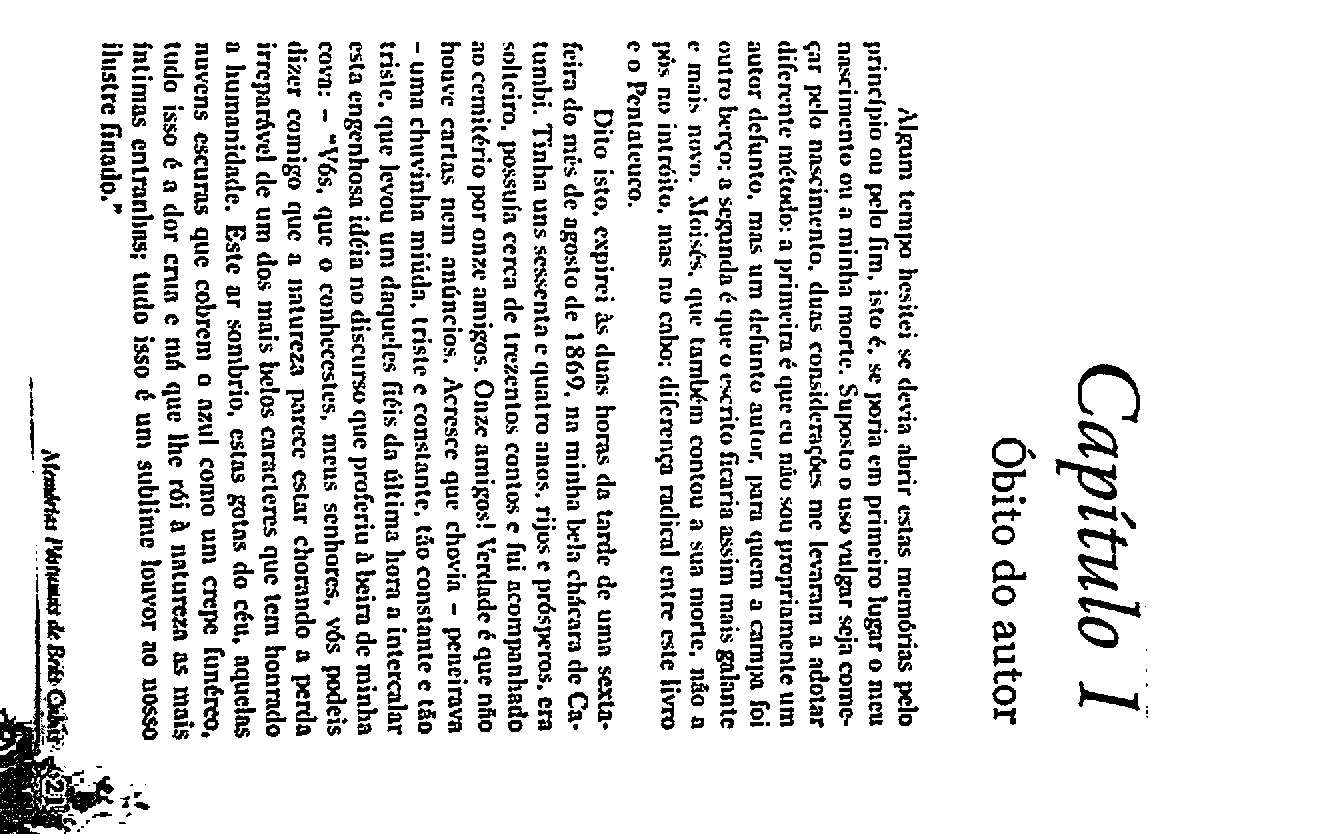

'Capítulo 1 Óbito do autor Algum tempo hesitei se devia abrir estas memórias pelo princípio ou pelo fim, isto é, se poria em primeiro o meu nascimento ou a minha morte. Suposto o use vulgar seja come- çar pelo nascimento, duas considerações me levaram a adotar diferente método: a é que cu não sou um autor defunto, mas um defunto autor, para quem a campa foi outro berço: segunda é que o escrito ficaria assim mais galante e mais novo. Moisés, que também contou a sua morte, não a pôs no intróito, mas no cobo; diferença radical entre este livro € o Dito isto, expirei às duas horas da tarde de uma sexta- feira do mês de agosto de 1869, minha bela chácara de Ca- tumbi. Tinha uns sessenta e quatro anos, rijos e prósperos, era solteiro, possuía cerca de trezentos contos e fui scompanhado an cemitério por onze amigos. Onze amigos! Verdade é que não houve cartas nem anúncios. Acresce que chovia - peneirava - umn chuvinha miúda, triste e constante, tão constante e tão triste, que levou um daquele

In [19]:
imagem, texto = extrair_texto(pagina_1)
cv2_imshow(imagem)
texto

### 4.2.2 Imagem na horizontal 2

In [20]:
imagem, texto = extrair_texto(pagina_2)
texto

'vat/ — Óbito do autor Algum tempo hesitei se devia abrir estas memórias pelo princípio ou pelo fim, isto é, se poria em primeiro Jugar o meu nascimento ou a minha morte. Suposto o uso vulgar seja come- çar pelo nascimento, duas considerações me levaram a adotar diferente método: a primeira é que cu não sou um autar defunto, mas um defunto autor, para «quem a campa foi outro berço: a segunda é que o escrito ficaria assim mais galante e mais novo. Moisés, que também contou a sua morte, não a pôs no intróito, mas no cobo; diferença radical entre este c o Dito isto, expirei às duas horas da tarde de uma sexta- feira do mês de agosto de 1869, na minha bela chácara de Ca- tumbi. Tinha uns sessenta e quatro anos, rijos e prósperos, era solteiro, possufa cerca de trezentos contos e fui acompanhado no cemitério por onze amigos. Onze amigos! é que não houve cartas nem anúncios. Acresce que chovia - peneirava — uma chuvinha miúda, triste e constante, tão constante e tão triste, que levou um daqu

### 4.2.3 Imagem levemente inclinada

In [21]:
imagem, texto = extrair_texto(pagina_3)
texto

"  hesitej devia , Menórias Princípio o lo fim to é, se Doria Primeiro lugar o ua ha orte, Sy, Vulgar seja come. s2 pelo ime, h a r d:!m:nl étodo: Prin nx um defy. À Um defunto a foi é &lante & Mais novo À * fontou a te, não DÔS no in 2o, m o cabo; dical en livro    * às ras da feira do ês de de 1869, inha tumbi. sesseng º Quatro an . snltcíro,.' tfa de tos é 40 T s. ânúncios, Acresce e chovia Uma miúda, e cons QE levou 1is da tsta no Seurso que Iue & » Meus senh dizer « migo q 2 € estar c d mais q te €Stas go que cobrem p com tudo é e má que rái , do isso é um sublime ilusire"

### 4.2.4 Imagem de ponta-cabeça

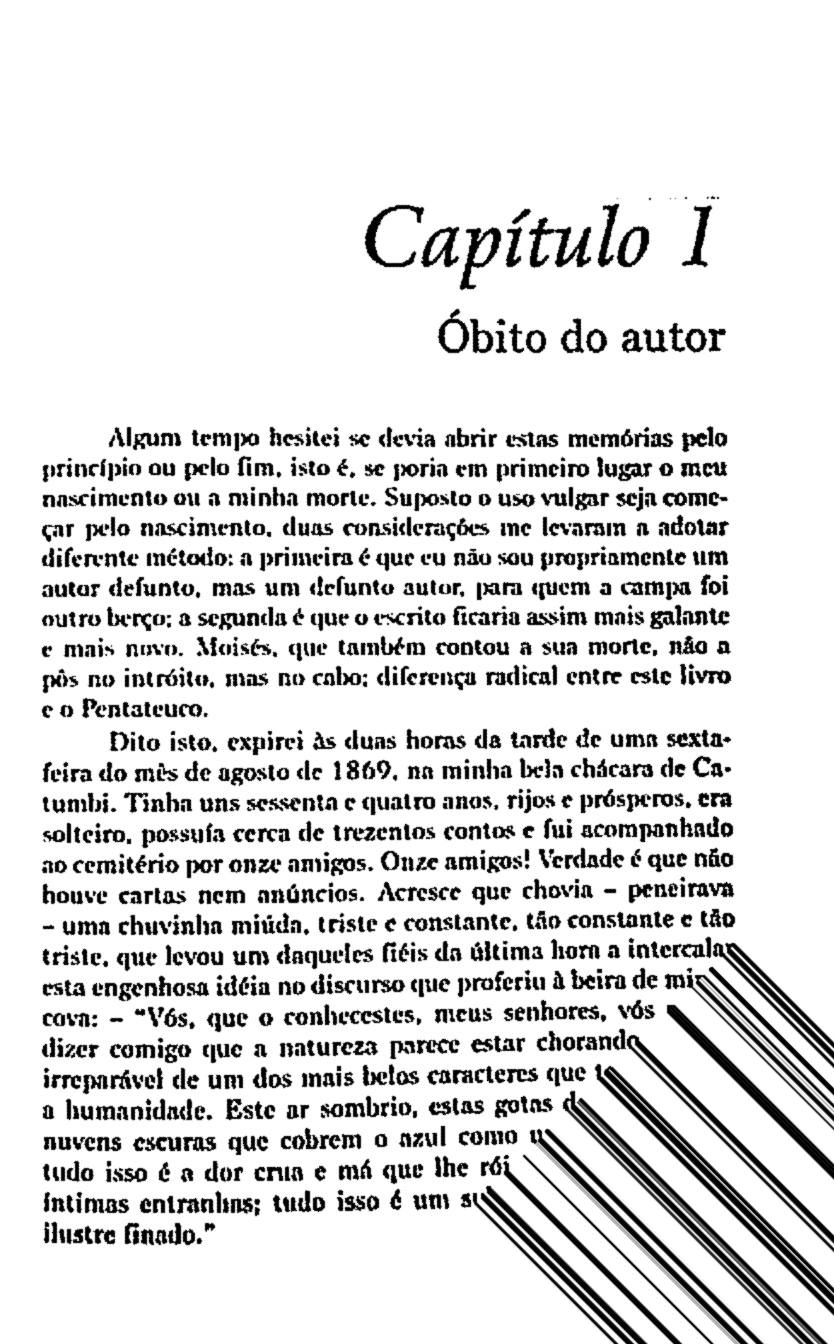

'Capítulo 1 Óbito do autor Algum tempo hesitei se devia abrir estas memórias pelo princípio ou pelo fim, isto é, se poria em primeiro o meu nascimento ou a minha morte. Suposto o uso vulgar seja come- çar pelo nascimento, duas considerações me levaram a adotar diferente método: a primeira é que eu não sou um autar defunto, mas um defunto autor, para quem a campa foi outro a segunda é que o escrito ficaria assim mais galante e mais Moisés, que também contou à sua morte, não a pôs no intróito, mas no cobo; diferença radical entre este c o Pentateuco, Dito expirei às duas horas da tarde de uma sexta- feira do mês de agosto de 1869, minha bela chácara de Ca- tumbi. Tinha uns sessenta e quatro anos, e prósperos, era solteiro, cerca de trezentos contos e fui acompanhado ao cemitério por onze amigos. Onze amigos! Verdade é que não houve cartos nem anúncios. Acresce que chovia - peneirava - uma chuvinha miúda, triste e constante, tão constante e tão triste, que levou um daqueles fiéis da últim

In [22]:
imagem, texto = extrair_texto(pagina_4)
cv2_imshow(imagem)
texto

## 4.3 Sombra

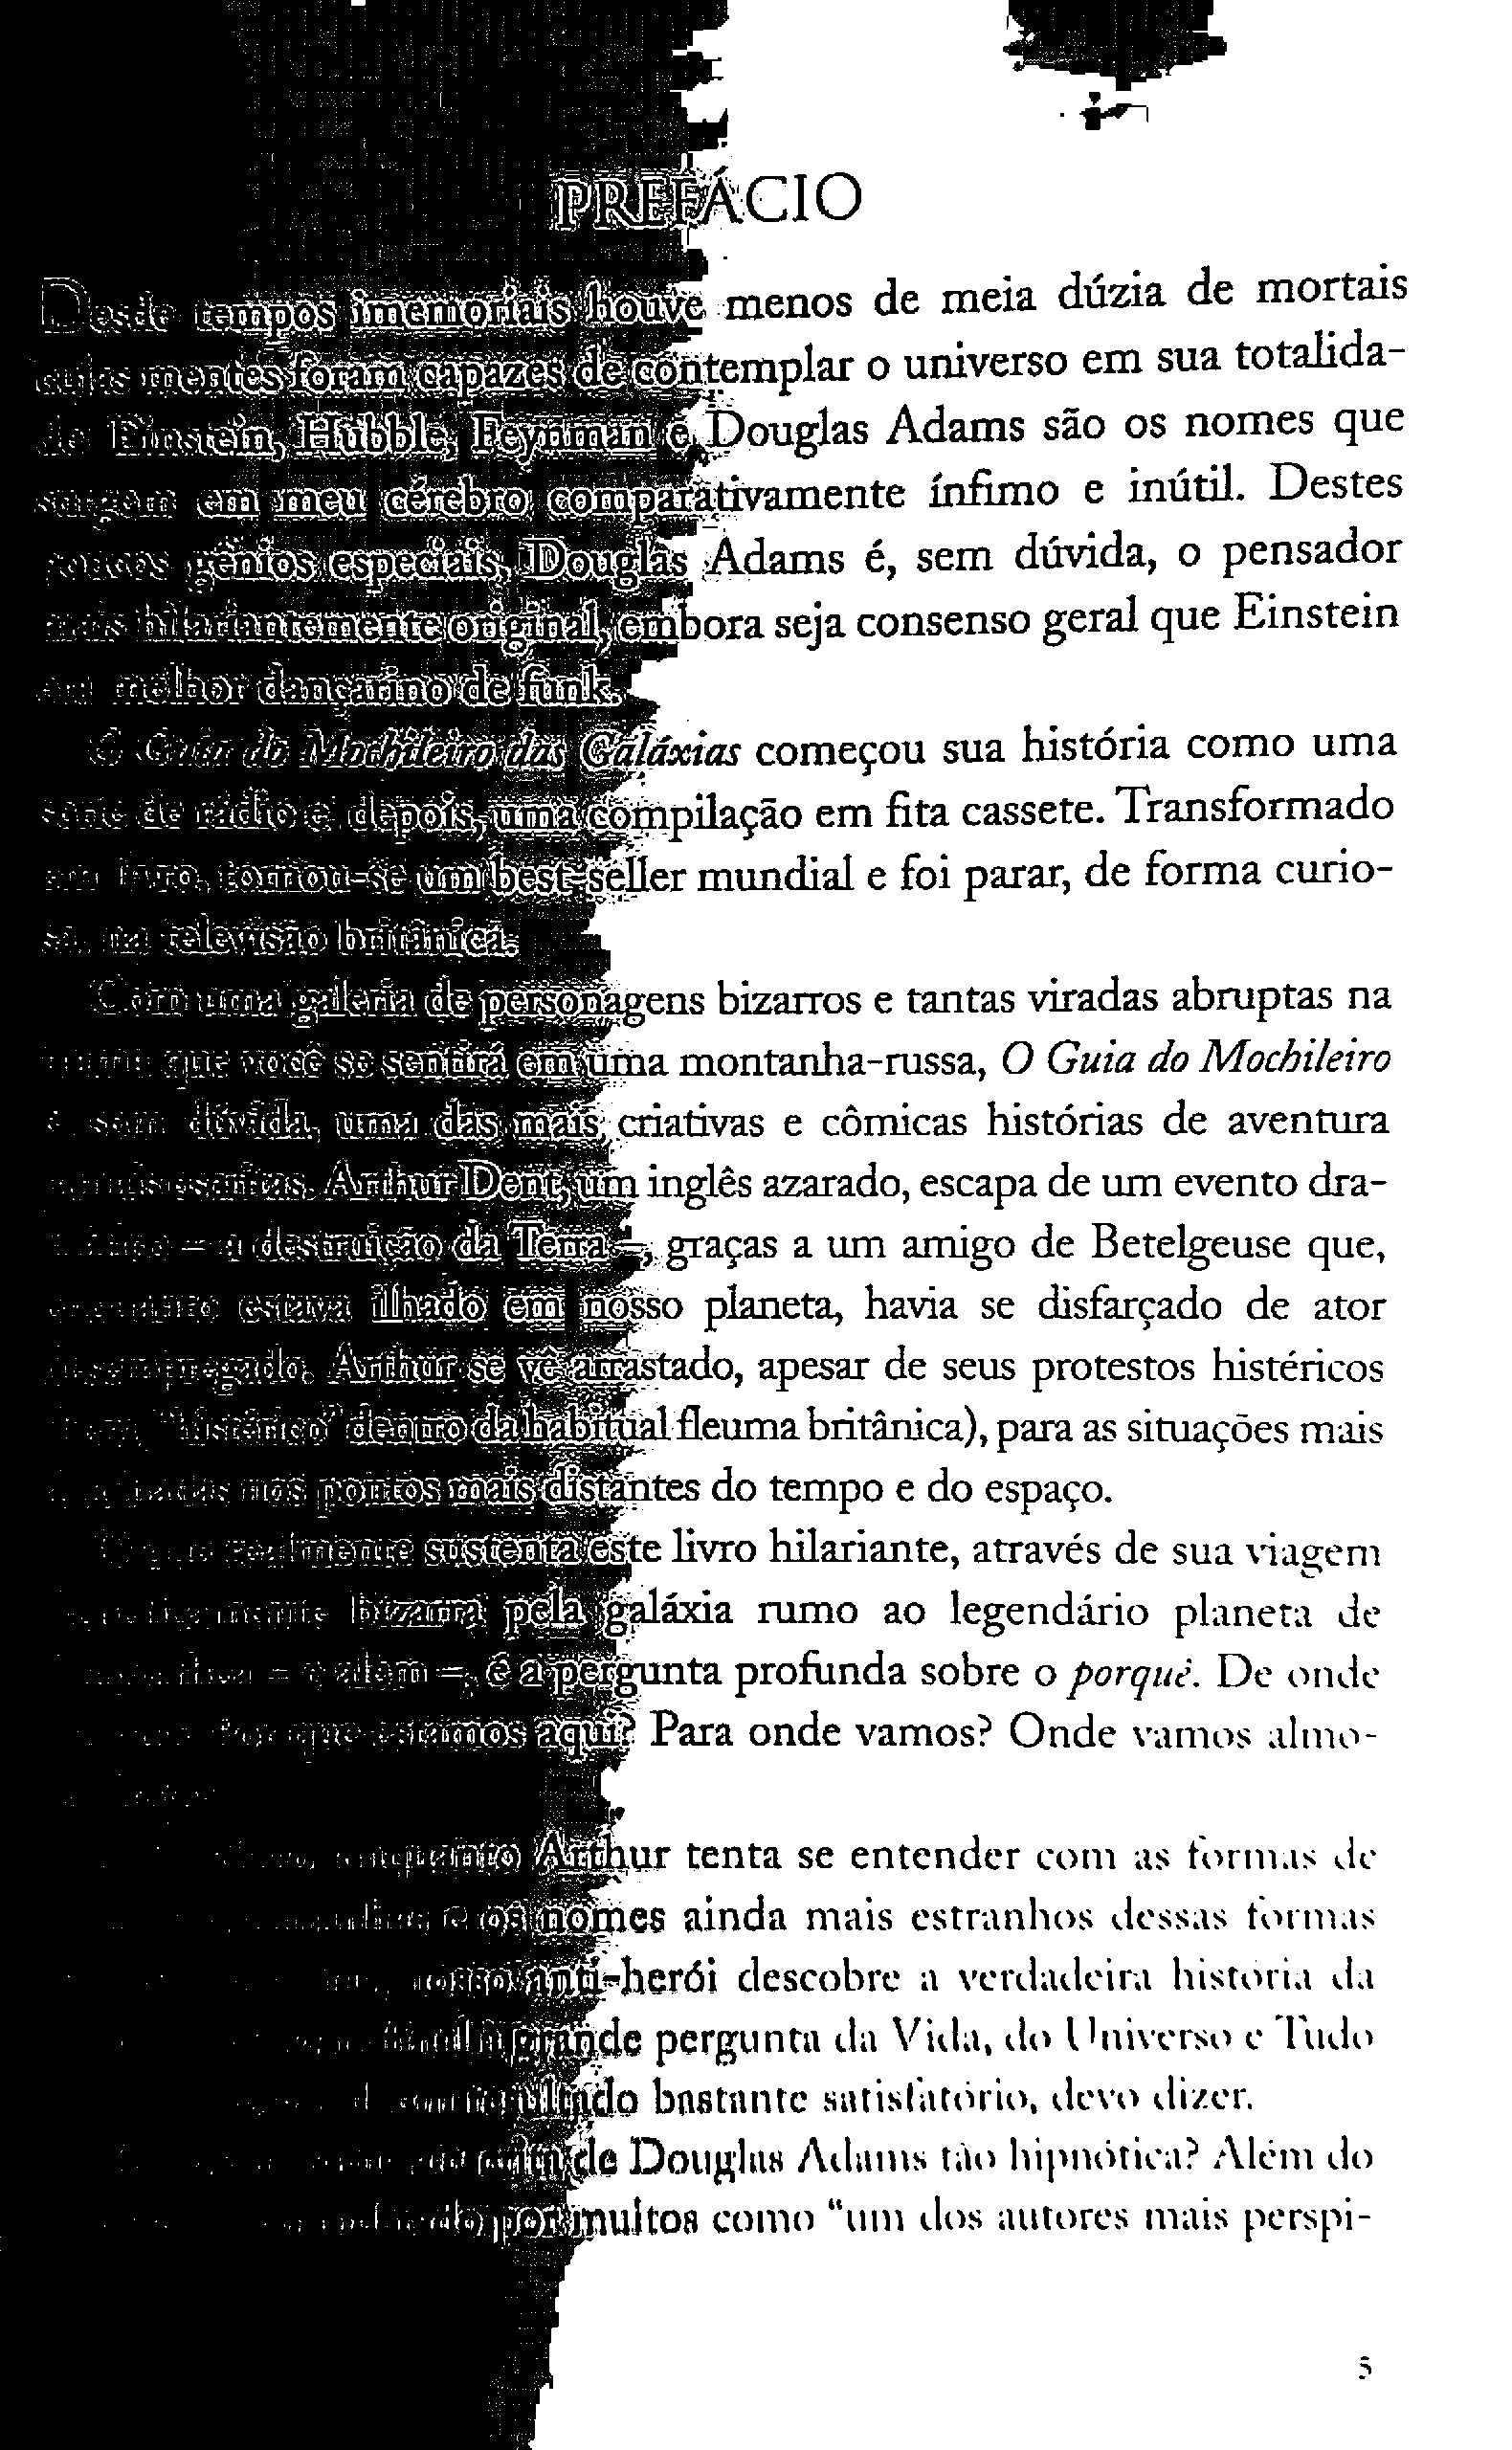

"'é menos de meia dúzia de o universo em sua totalida- Adams são os nomes que ínfimo e inútil. Destes o ;Adams é, sem dúvida, o pensador seja consenso geral que Einstein começou sua história como uma em fita cassete. Transformado “i”,w!_'ª”ízlªln'íº mundial e foi parar, de forma curio- bizarros e tantas viradas abruptas na »;aaíà:à montanha-russa, O Guia do Mochileiro criativas e cômicas histórias de aventura 1 inglês azarado, escapa de um evento dra- olç—:'rgllºfmªª . Braças a um amigo de Betelgeuse que, flhais planeta, havia se disfarçado de ator apesar de seus protestos histéricos «—ur gLªjlír;&(É_LjÍn“_n britânica), para as situações mais &“n*rãíís gf do tempo e do espaço. livro hilariante, através de sua viagem ]mlla, rumo ao legendário de =(«?_qu profunda sobre o porque. De onde ? Para onde vamos? Onde vamos almo- tenta se entender com às tormas de (.,m_qº ainda mais estranhos dessas tormas | | descobre à verdadeira da pergunta da Vida, do Universo e Tudo am devo dizer. 6 Douglhs

In [23]:
imagem, texto = extrair_texto(pagina_sombra)
cv2_imshow(imagem)
texto